# Editing and masking of circuits

In this notebook we show editing and masking of circuits.

In [ ]:
from genQC.imports import *
from genQC.pipeline.diffusion_pipeline import DiffusionPipeline
from genQC.inference.infer_srv import convert_tensors_to_srvs, schmidt_rank_vector
import genQC.platform.qcircuit_dataset_construction as data_const
import genQC.util as util
from qiskit.quantum_info import DensityMatrix

In [ ]:
device = util.infer_torch_device()  # use cuda if we can
util.MemoryCleaner.purge_mem()      # clean existing memory alloc

[INFO]: Cuda device has a capability of 8.6 (>= 8), allowing tf32 matmul.


## Setup and load

Load the pre-trained model

In [ ]:
model_path = "../../saves/qc_unet_config_SRV_3to8_qubit/"
pipeline   = DiffusionPipeline.from_config_file(model_path, device)  

[INFO]: `genQC.models.unet_qc.QC_Cond_UNet` instantiated from given config on cuda.
[INFO]: `genQC.models.frozen_open_clip.CachedFrozenOpenCLIPEmbedder` instantiated from given config on cuda.
[INFO]: `genQC.models.frozen_open_clip.CachedFrozenOpenCLIPEmbedder`. No save_path` provided. No state dict loaded.


Set 20 sample steps and use rescaled guidance-formula.

In [ ]:
pipeline.guidance_sample_mode = "rescaled"
pipeline.scheduler.set_timesteps(40) 
g = 7.5

## 1. Editing

Sample a random circuit with desired parameters as the circuit we want to edit:

In [ ]:
srv_init       = [1, 1, 1, 2, 2]   # psi_0 state
desired_length = 5                 # 5 gates initially placed

SRV is [1, 1, 1, 2, 2]


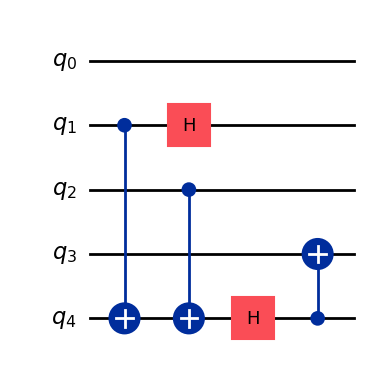

In [ ]:
init_qc = data_const.get_specific_rnd_srv_circuit(srv_init, desired_length, pipeline.gate_pool)
print("SRV is", schmidt_rank_vector(DensityMatrix(init_qc)))
init_qc.draw("mpl")

The editing taks is analogous to image editing, we do img2img with conditioning and copy non-edit areas at every time step. Also called `latent_filling`.

In [ ]:
def create_edited_circuits(pipeline, samples, qc, prompt, new_length, num_of_qubits, system_size, t_start_index):
    #-------------------------------------------
    # set mask - appending mask!
    old_length = len(qc.data)

    qubit_mask = torch.ones((system_size, new_length), device=device)
    qubit_mask[:, :old_length] = 0
    
    #-------------------------------------------
    # prepare and encode
 
    gate_classes = data_const.gate_pool_to_gate_classes(pipeline.gate_pool)
   
    emb_org_image = data_const.encode_circuit(qc, system_size, gate_classes, new_length).unsqueeze(0).to(device)
    emb_org_image = pipeline.model.embedd_clrs(emb_org_image)

    emb_org_images = emb_org_image.repeat(samples, *[1]*(emb_org_image.dim()-1))
    
    #-------------------------------------------
    # prep condition
    
    c = pipeline.text_encoder.tokenize_and_push_to_device(str(prompt))
    c = c.repeat(samples, *[1]*(c.dim()-1))

    #-------------------------------------------
    # latent fill
    out_tensor = pipeline.latent_filling(emb_org_images, qubit_mask, c=c, g=g, no_bar=False, t_start_index=t_start_index)
    out_tensor = pipeline.model.invert_clr(out_tensor)
    out_tensor = out_tensor[:, :num_of_qubits]
    out_tensor = torch.unique(out_tensor, dim=0) # we only are interested in unique circuits
   
    qc_list, error_cnt, srv_list = convert_tensors_to_srvs(out_tensor, pipeline.gate_pool, place_barrier=True)

    return qc_list, srv_list

In [ ]:
samples    = 16   # how many circuits we sample
new_length = 16   # how many gates the model can place 

srv_target    = [2, 2, 2, 2, 2]  # desired target SRV

num_of_qubits = len(srv_target)
t_start_index = t_start_index = int(0.05 * pipeline.scheduler.timesteps.shape[0])  # time step index at which we start denoising

prompt = f"Generate SRV: {srv_target}"  # model was trained with this phrase
prompt

'Generate SRV: [2, 2, 2, 2, 2]'

In [ ]:
# returns only distinct circuits
edited_qc, srv_list = create_edited_circuits(pipeline, samples, init_qc, prompt, new_length, num_of_qubits, num_of_qubits, t_start_index)

  0%|          | 0/38 [00:00<?, ?it/s]

Pick only correct ones:

In [ ]:
correct_edited_qc = []
for qc,srv in zip(edited_qc, srv_list):
    if srv==srv_target: correct_edited_qc.append(qc)
print(f"We found {len(correct_edited_qc)} correct distinct solutions.")

We found 13 correct distinct solutions.


Compare: initial circuit

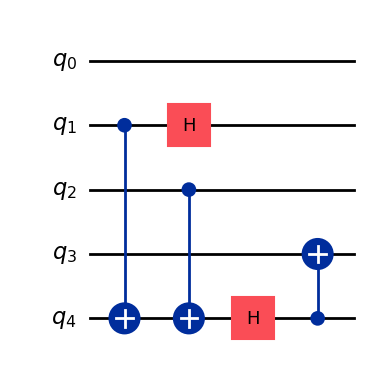

In [ ]:
init_qc.draw("mpl")

v.s. edited:

SRV is [2, 2, 2, 2, 2]


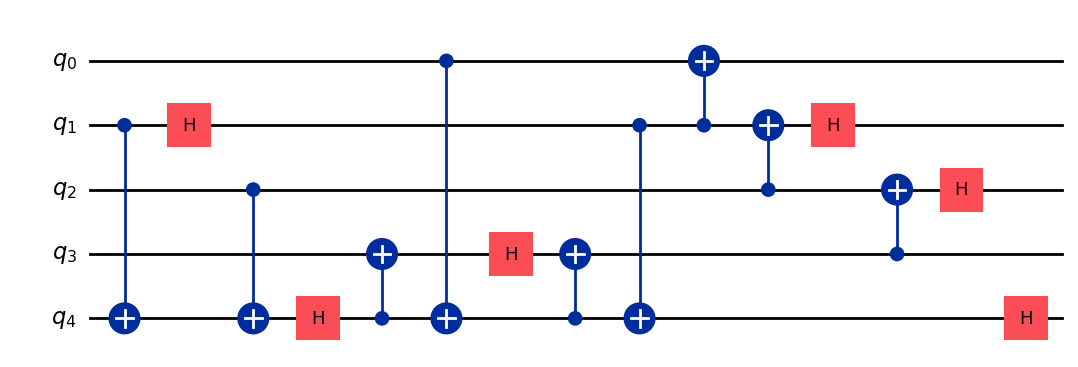

In [ ]:
print("SRV is", schmidt_rank_vector(DensityMatrix(correct_edited_qc[0])))
correct_edited_qc[0].draw("mpl", plot_barriers=False)

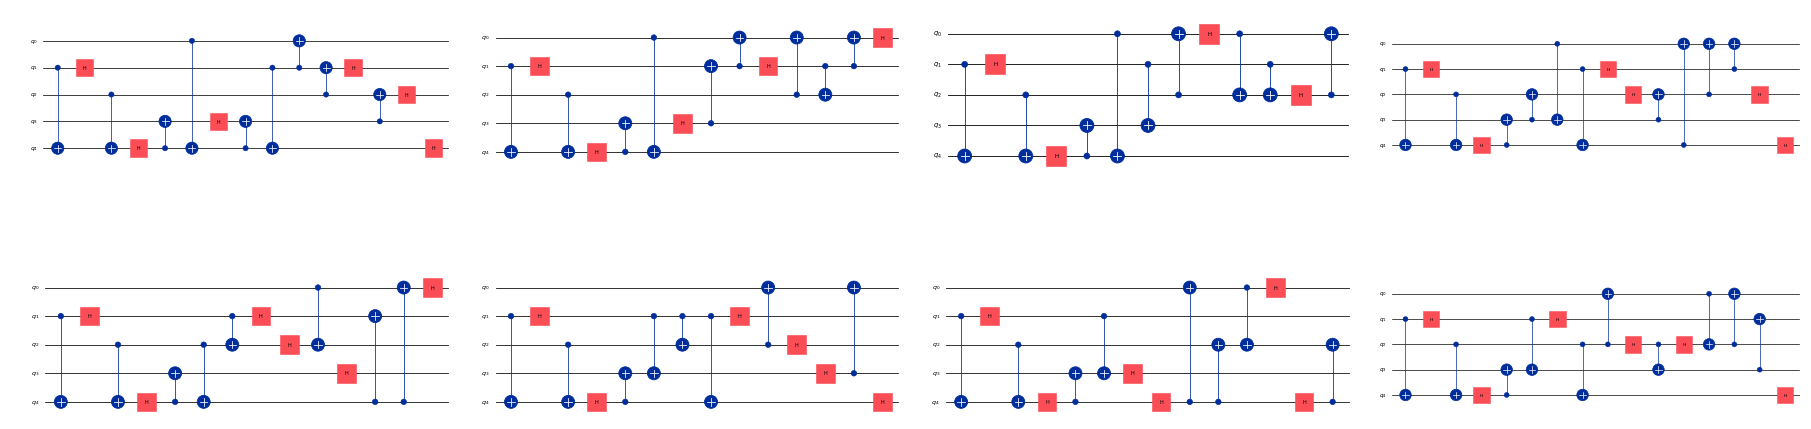

In [ ]:
fig, axs = plt.subplots(2,4, figsize=(18,5), constrained_layout=True)
for qc,ax in zip(correct_edited_qc, axs.flatten()): 
    qc.draw("mpl", plot_barriers=False, ax=ax)
plt.show()

## 2. Masking

First we set a desired mask, i.e. a specific layout of a quantum processor.

In [ ]:
max_gates     = 16
num_of_qubits = 5

d = 3
#------
def con_set(q1, q2, x, d): 
    qubit_mask[q1, x:x+d] = 1
    qubit_mask[q2, x:x+d] = 1
    return x+d

#------
x = 0

qubit_mask = torch.zeros((num_of_qubits, max_gates), device=device) # mask: ones are getting filled, zeros are fixed !
x = con_set(0, 1, x, d)
x = con_set(1, 2, x, d)
x = con_set(1, 3, x, d)
x = con_set(3, 4, x, d)

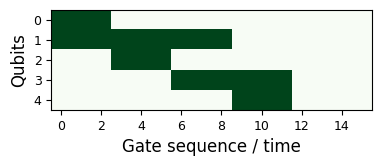

In [ ]:
def plot_mask():
    fig = plt.figure(figsize=(3.7,2), constrained_layout=True)
    plt.imshow(qubit_mask.cpu(), cmap="Greens")
    plt.xticks(range(0, qubit_mask.shape[1], 2),fontsize=9)
    plt.yticks(range(num_of_qubits), fontsize=9)
    plt.xlabel("Gate sequence / time", fontsize=12)
    plt.ylabel("Qubits", fontsize=12)
    plt.show()
plot_mask()

In [ ]:
def get_emb_org_images(pipeline, samples, system_size, max_gates, target_num_gates, target_num_bits, qubit_mask):
    org_image = torch.zeros((1, system_size, max_gates), device=device, dtype=torch.int32) 
    
    padd_tok = len(pipeline.gate_pool) + 1
    padd_pos = (torch.ceil(torch.tensor(target_num_gates) / 4) * 4).to(torch.int32)
    org_image[:,                :, padd_pos:] = padd_tok
    org_image[:, target_num_bits:,          ] = padd_tok

    emb_org_image  = pipeline.model.embedd_clrs(org_image)
    emb_org_images = emb_org_image.repeat(samples, *[1]*(emb_org_image.dim()-1))
    
    return emb_org_images

In [ ]:
def generate_pattern_SRV(pipeline, prompt, samples, system_size, num_of_qubits, max_gates, qubit_mask, t_start_index=0, target_num_gates=None, target_num_bits=None): 

    if not exists(target_num_gates):
        target_num_gates = max_gates

    if not exists(target_num_bits):
        target_num_bits = num_of_qubits
    
    emb_org_images = get_emb_org_images(pipeline, samples, system_size, max_gates, target_num_gates, target_num_bits, qubit_mask)

    #----------------
    # prep condition

    c = pipeline.text_encoder.tokenize_and_push_to_device(str(prompt))
    c = c.repeat(samples, *[1]*(c.dim()-1))

    #----------------
    # latent fill
    
    out_tensor = pipeline.latent_filling(emb_org_images, qubit_mask, c=c, g=g, no_bar=False, t_start_index=t_start_index)
    out_tensor = pipeline.model.invert_clr(out_tensor)
    out_tensor = out_tensor[:, :num_of_qubits]
    out_tensor = torch.unique(out_tensor, dim=0)
     
    qc_list, error_cnt, srv_list = convert_tensors_to_srvs(out_tensor, pipeline.gate_pool, place_barrier=True)

    return qc_list, srv_list

Now generate circuits corresponding to the mask. 

In [ ]:
samples    = 512              # how many circuits we sample
srv_target = [2, 1, 2, 2, 2]  # desired target SRV

assert len(srv_target)==qubit_mask.shape[0]

prompt = f"Generate SRV: {srv_target}"  # model was trained with this phrase
prompt

'Generate SRV: [2, 1, 2, 2, 2]'

In [ ]:
qc_list, srv_list = generate_pattern_SRV(pipeline, prompt, samples, num_of_qubits, num_of_qubits, max_gates, qubit_mask, t_start_index=1)

  0%|          | 0/39 [00:00<?, ?it/s]

Pick only correct ones:

In [ ]:
correct_qc = []
for qc,srv in zip(qc_list, srv_list):
    if srv==srv_target: correct_qc.append(qc)
print(f"We found {len(correct_qc)} correct distinct solutions.")

We found 13 correct distinct solutions.


Let's plot them. Mask:

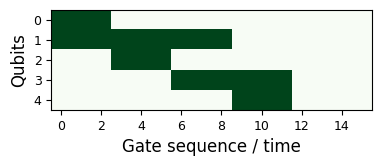

In [ ]:
plot_mask()

v.s. solution:

SRV is [2, 1, 2, 2, 2]


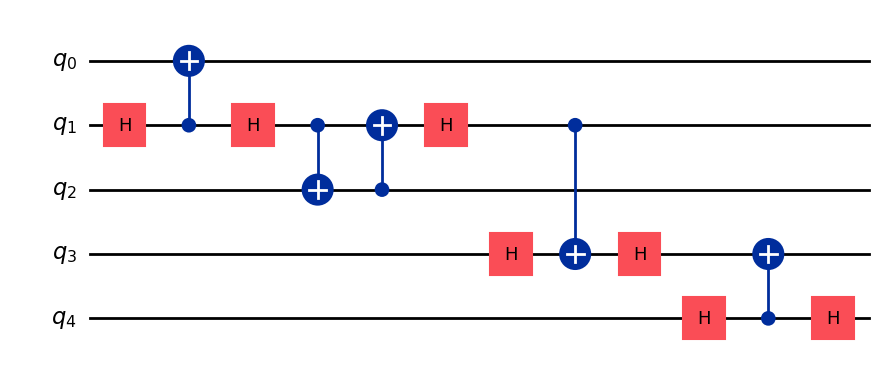

In [ ]:
print("SRV is", schmidt_rank_vector(DensityMatrix(correct_qc[0])))
correct_qc[0].draw("mpl", plot_barriers=False)

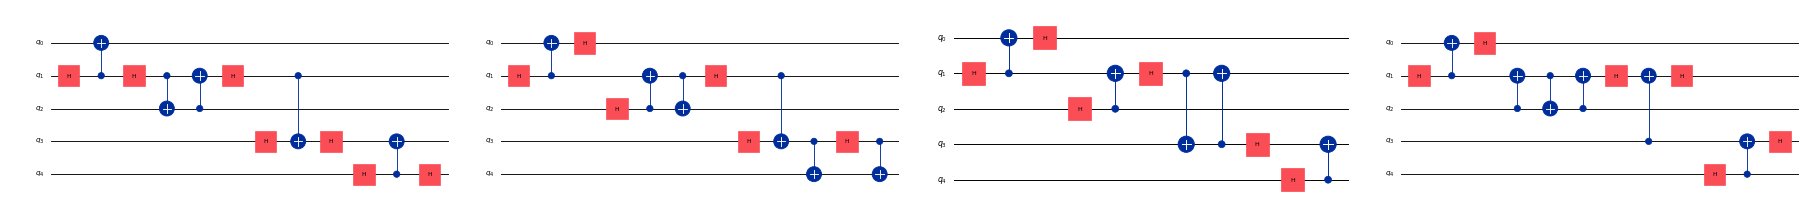

In [ ]:
fig, axs = plt.subplots(1, min(len(correct_qc), 4), figsize=(18,5), constrained_layout=True)
for qc,ax in zip(correct_qc, axs.flatten()): 
    qc.draw("mpl", plot_barriers=False, ax=ax)
plt.show()